In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib
from openpyxl import load_workbook
from imblearn.over_sampling import SMOTE
from collections import Counter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [4]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Tracao'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Tracao
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1381.306200,1400.000000,1336.700433,1485.149012,2033.803036,582.270289,78.744569,110.649690,0.390286,0.511169,...,NaN,NaN,4.324657,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1333.646128,1400.000000,1344.118231,1494.898329,2030.875266,589.559597,77.362570,113.253684,0.391539,0.512543,...,NaN,NaN,5.318897,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1501.031945,1321.957851,1236.117841,1357.110969,1932.820439,NaN,69.779501,94.943599,0.439284,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.604391,4.905901,1


In [5]:
# Linha a ser adicionada
linha = "1380,0000/ 1300/ 1190,0000/ 1551,7200/ 1880/ 469,6/ 114,32/ 86,58/ 0,432/ 0,519/ 629,4/ 788,8/ 189,6000/ 170/ 62/ 22,0000/ 0/ 0/ 245/ 62/ 22/ 0/ 0/ 2/ 69,4/6,8000/ 15/ 39/ 370,3/ 81/ 180/ 52/ 160,0000/ 7,0800/ 20,7/ 38/ 9,5/ 2080/ 30/ 6,4699/ 8,7287/ 3,6/ 0/ 0/ 43/ 41/ 4,2/ 4,4/ 5/"

# Separar os valores da linha
valores = linha.split("/")

# Converter os valores para float
valores_float = [float(valor.replace(",", ".")) for valor in valores[:-1]]

# Adicionar a nova linha ao final do DataFrame existente
df.loc[len(df)] = valores_float

# Verificar o DataFrame atualizado
print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0               NaN                  NaN                 NaN          NaN   
1       1381.306200          1400.000000         1336.700433  1485.149012   
2       1333.646128          1400.000000         1344.118231  1494.898329   
3               NaN                  NaN                 NaN          NaN   
4       1501.031945          1321.957851         1236.117841  1357.110969   
...             ...                  ...                 ...          ...   
996     1377.268578          1201.797218         1243.067016  1640.287870   
997     1372.914498          1268.915907         1192.045423  1495.988045   
998     1409.390177          1208.116060         1226.976072  1655.560910   
999     1341.161553          1358.322638         1291.644507  1610.775844   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento  DP_Altura do CG com relacao ao chao  MV_Eixo dianteir

In [6]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DMV_Lado Direito',
    'SD_Dimensoes dos pneus',
    'SD_Cambagem estatica',
    'SD_Convergência estatica',
    'ST_Dimensoes dos pneus',
    'ST_Cambagem estatica',
    'ST_Convergência estatica',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal', 
    'CD_Ganho de arfagem em desaceleracao longitudinal'
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [7]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 20 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   DP_Altura do CG com relacao ao chao                      232 non-null    float64
 1   MV_Eixo dianteiro                                        727 non-null    float64
 2   MV_Eixo Traseiro                                         727 non-null    float64
 3   DMV_Dianteira                                            727 non-null    float64
 4   PCG_X                                                    727 non-null    float64
 5   PCG_Y                                                    974 non-null    float64
 6   PCG_Z                                                    727 non-null    float64
 7   SD_Curso Positivo de projeto                             126 non-null    float64
 8   SD_Curso Negativo de projeto

In [8]:
# Descrição de dados
df.describe()

,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,SD_Curso Positivo de projeto,SD_Curso Negativo de projeto,ST_Curso Positivo de projeto,ST_Curso Negativo de projeto,MT_Potência maxima do motor,MT_Torque maximo do motor,MT_Relacao total_max,MT_Relacao total_min,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Tracao
count,232.000000,727.000000,727.000000,727.000000,727.000000,974.000000,727.000000,126.000000,126.000000,128.000000,123.000000,250.000000,254.000000,721.000000,717.000000,345.000000,280.000000,287.000000,259.000000,1001.000000
mean,536.370755,73.989382,104.117262,0.415691,266.083548,117.004248,-38.407896,146.468529,58.307205,139.142897,47.376931,7.075025,19.170142,28.658534,5.821272,51.314170,48.499346,7.508440,8.142833,3.001998
std,101.209640,11.370860,13.652935,0.026439,225.065243,199.951474,5941.035934,40.126818,17.259232,45.466058,14.736482,0.381005,1.155904,5.517958,1.247176,4.492536,5.590066,4.179142,4.826260,1.415626
min,292.610000,48.185803,76.072417,0.327360,-268.343676,-106.854976,-141682.766178,40.000000,19.000000,22.072990,17.763000,5.137429,14.685439,3.291627,0.777981,40.246896,26.957654,3.778791,3.489945,1.000000
25%,491.837978,67.894112,95.508310,0.398517,91.323509,-0.445142,171.500595,127.470837,48.293074,103.400000,37.073091,6.874877,18.607421,26.544491,4.975271,47.257656,44.311471,4.663988,4.914653,2.000000
50%,532.175966,72.033821,103.007639,0.413994,182.300190,6.822527,251.071607,149.438036,54.433158,145.000000,46.530073,7.078313,18.782076,28.798798,5.771534,51.758085,49.108729,6.141869,6.727704,3.000000
75%,569.046267,79.170545,110.439238,0.435010,425.847877,172.336148,381.910555,171.535529,74.205258,170.771888,50.000000,7.411229,19.550941,31.551837,6.579420,55.068342,52.700329,9.020490,9.359668,4.000000
max,1024.146490,132.106420,163.996866,0.481743,863.791114,1028.393380,994.853698,326.501752,103.095996,245.000000,89.907768,7.780000,23.140000,54.690048,9.826116,67.091994,61.252327,28.800000,31.700000,5.000000


In [9]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.")    

'DP_Altura do CG com relacao ao chao' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 15.
'PCG_Z' tem 0.
'SD_Curso Positivo de projeto' tem 0.
'SD_Curso Negativo de projeto' tem 0.
'ST_Curso Positivo de projeto' tem 0.
'ST_Curso Negativo de projeto' tem 0.
'MT_Potência maxima do motor' tem 0.
'MT_Torque maximo do motor' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em asfalto ' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em asfalto' tem 0.
'CD_Tempo para atingir velocidade maxima em terra batida' tem 0.
'P_Tracao' tem 0.


## Limpeza

In [10]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 900 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Altura do CG com relacao ao chao                        769
MV_Eixo dianteiro                                          274
MV_Eixo Traseiro                                           274
DMV_Dianteira                                              274
PCG_X                                                      274
PCG_Y                                                       27
PCG_Z                                                      274
SD_Curso Positivo de projeto                               875
SD_Curso Negativo de projeto                               875
ST_Curso Positivo de projeto                               873
ST_Curso Negativo de projeto                               878
MT_Potência maxima do motor                                751
MT_Torque maximo do motor                                  747
MT_Relacao total_max                                       280
MT_Relacao total_min                                       284
CD_Velocidade maxima de 0 a 100 metros em asfalto      

In [11]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([  0,   3,   4,   5,   6,   7,   8,  11,  13,  14,
            ...
            984, 986, 988, 989, 990, 991, 992, 994, 997, 999],
           dtype='int64', length=578)
      DP_Altura do CG com relacao ao chao  MV_Eixo dianteiro  \
1                              582.270289          78.744569   
2                              589.559597          77.362570   
9                              419.766151         122.289083   
10                                    NaN          88.332169   
12                                    NaN          70.143112   
...                                   ...                ...   
993                                   NaN          70.225517   
995                            548.012531          59.428353   
996                                   NaN          67.091455   
998                                   NaN          65.555789   
1000                           469.600000         114.320000   

      MV_Eixo Traseiro  DMV_Dianteira       PCG_X   

In [12]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Tracao'] = df['P_Tracao'].replace(mapeamento)

print(df['P_Tracao'])

1       0.0
2       0.0
9       0.0
10      0.0
12      0.0
       ... 
993     4.0
995     4.0
996     4.0
998     4.0
1000    4.0
Name: P_Tracao, Length: 423, dtype: float64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=False)

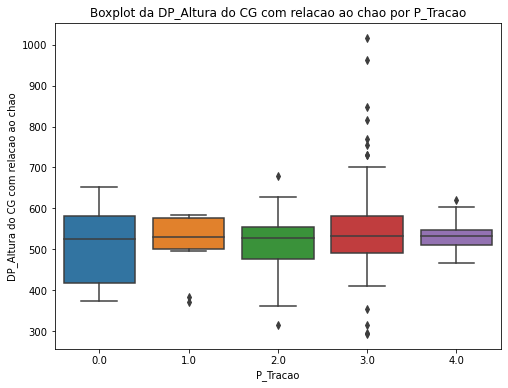

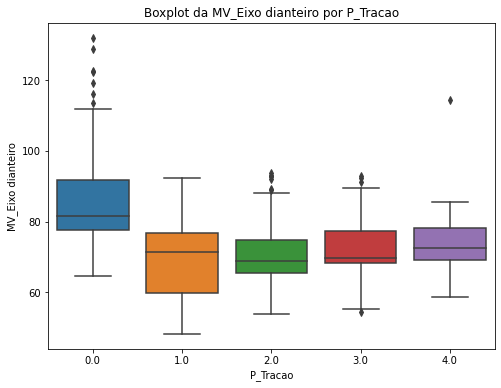

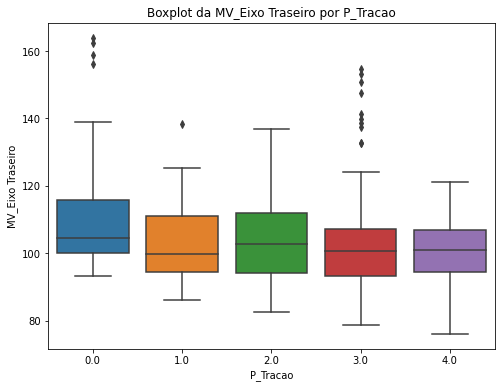

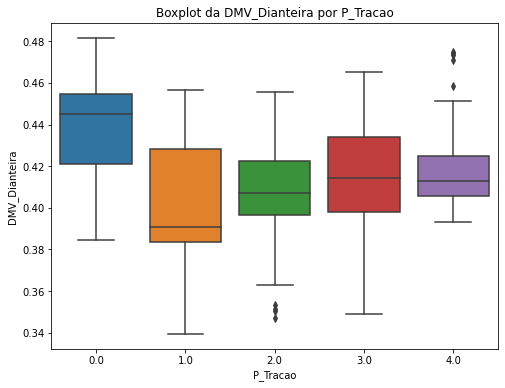

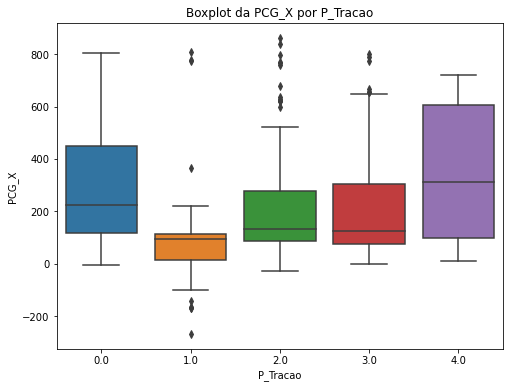

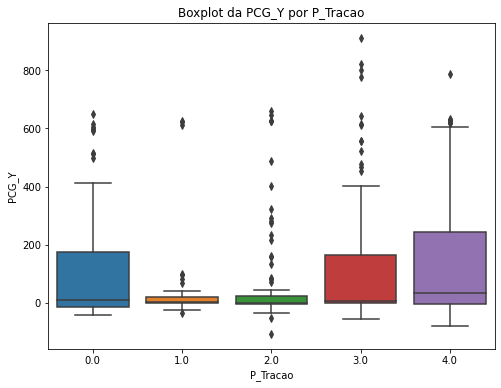

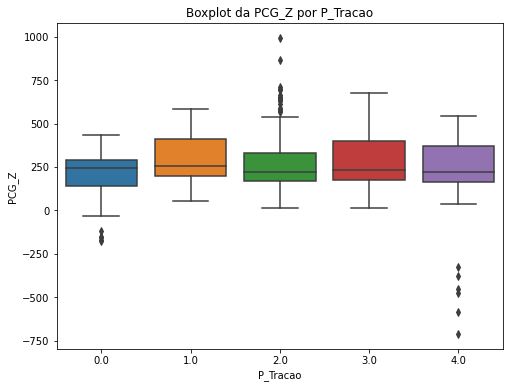

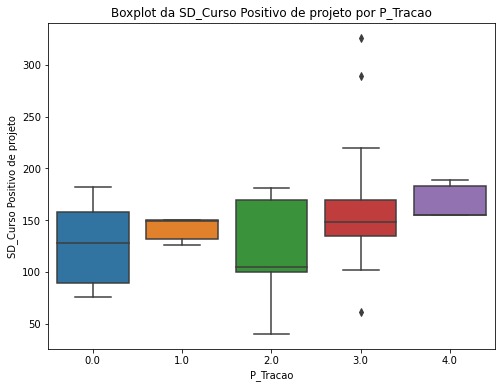

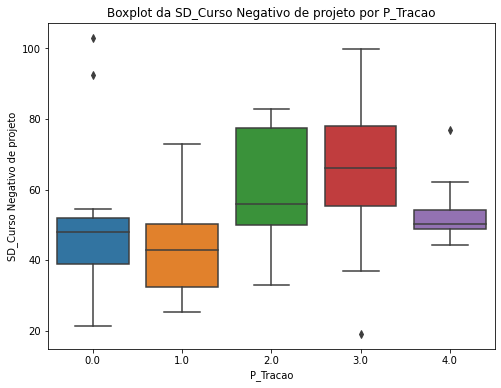

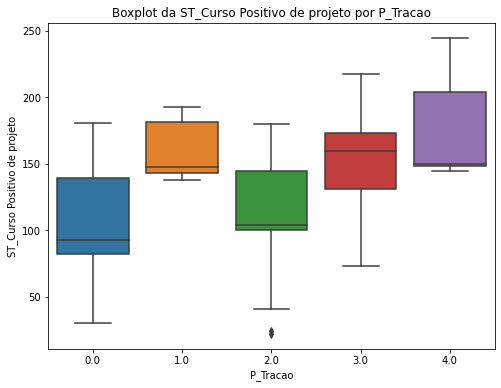

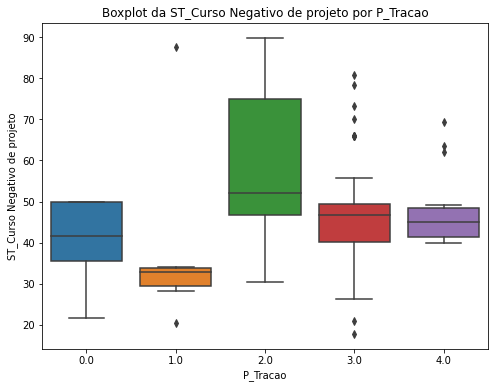

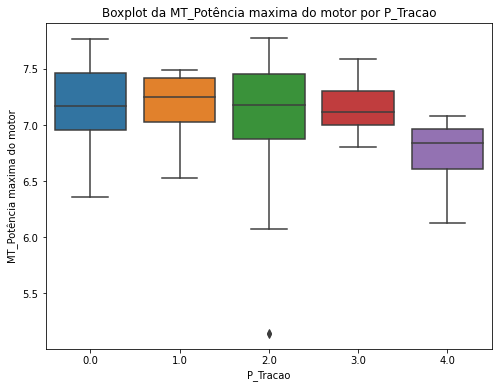

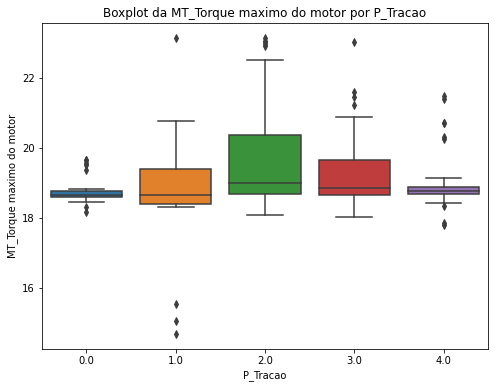

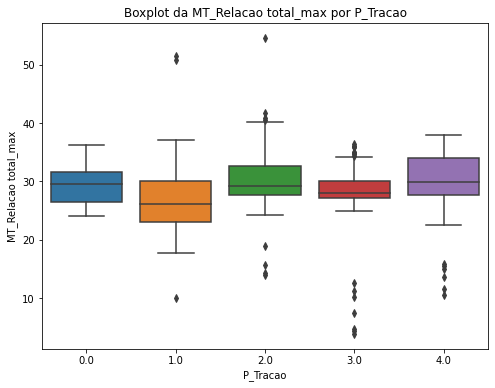

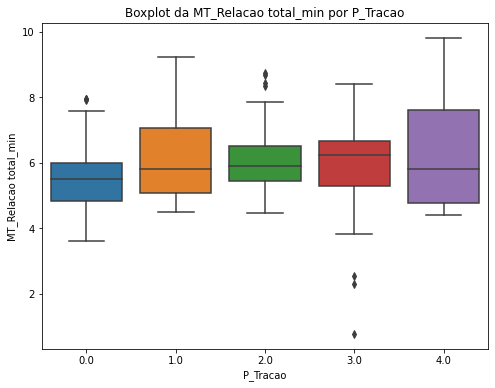

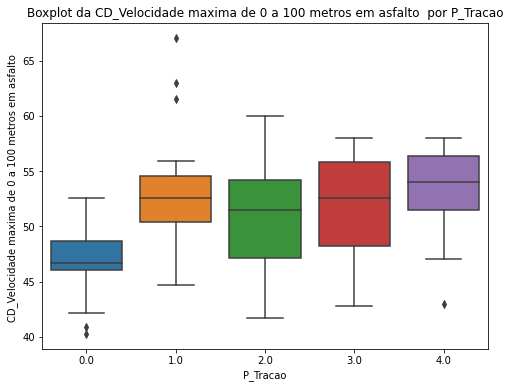

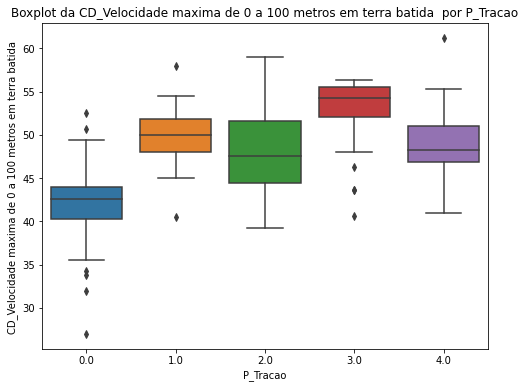

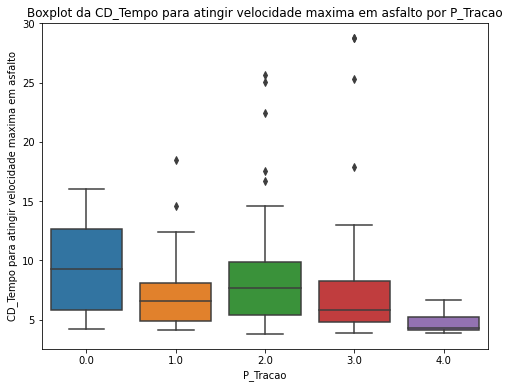

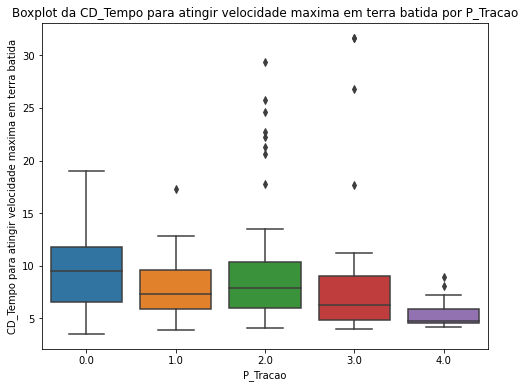

In [13]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Tracao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Tracao', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Tracao')
        plt.ylabel(coluna)
        plt.xlabel('P_Tracao')
        plt.show()

In [14]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Tracao']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Tracao'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Tracao'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Tracao'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

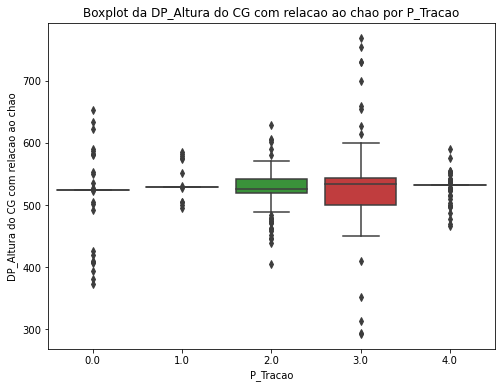

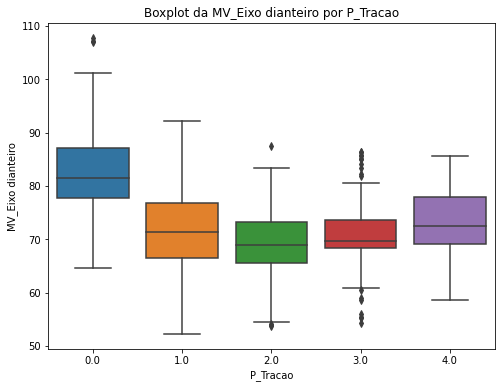

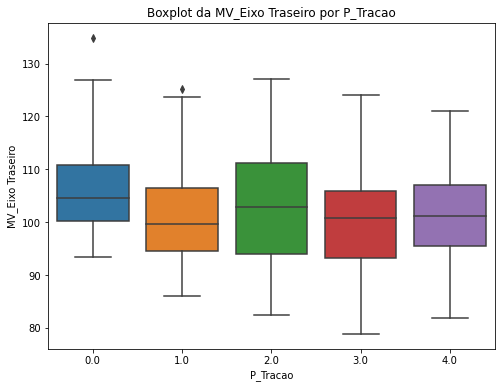

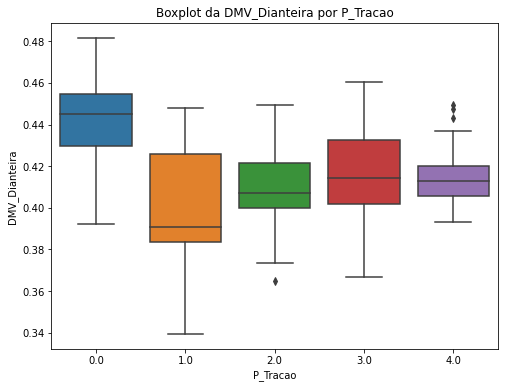

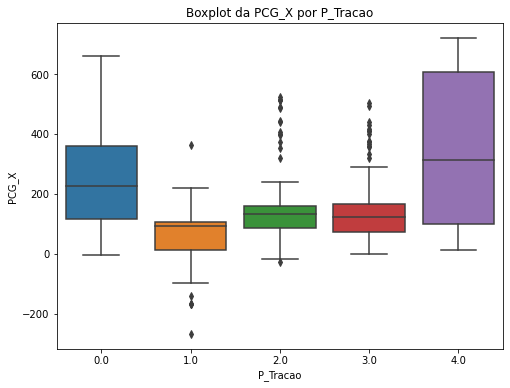

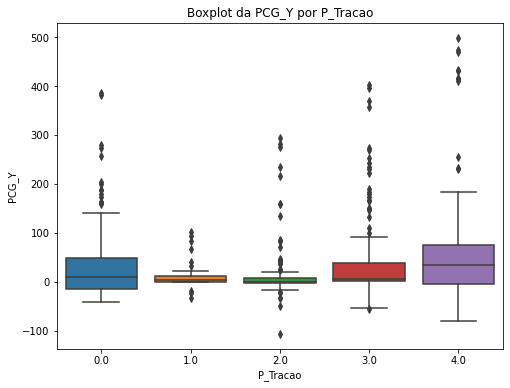

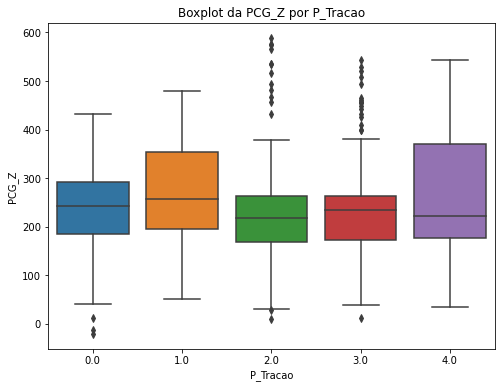

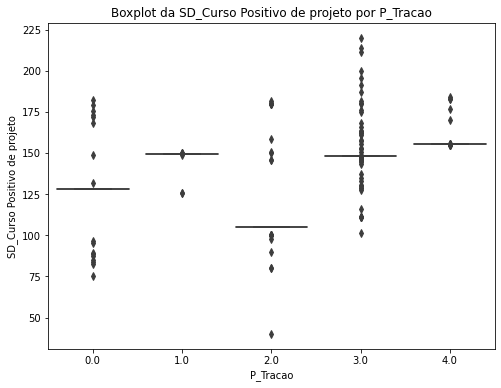

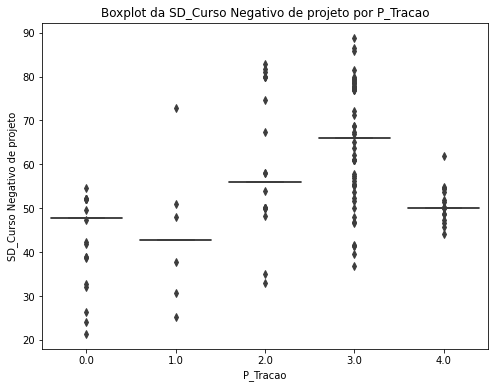

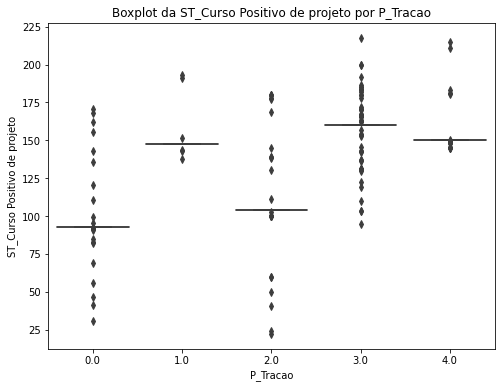

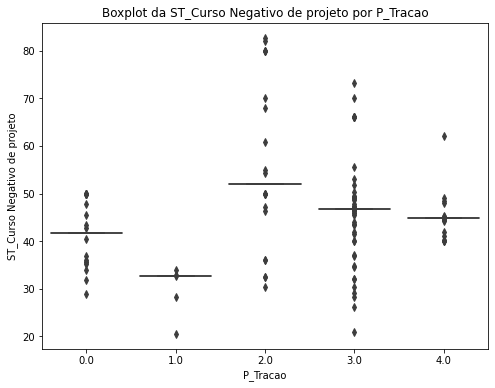

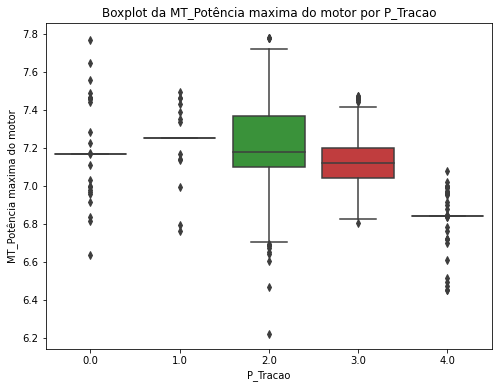

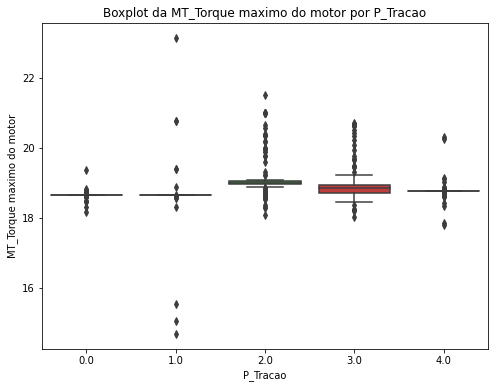

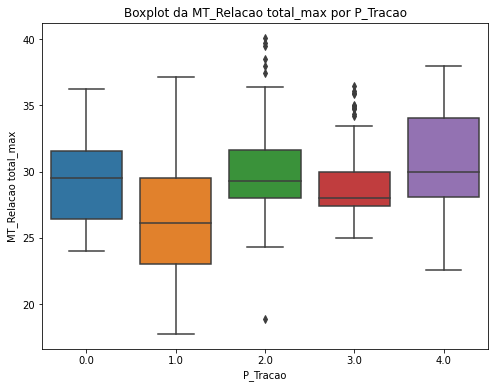

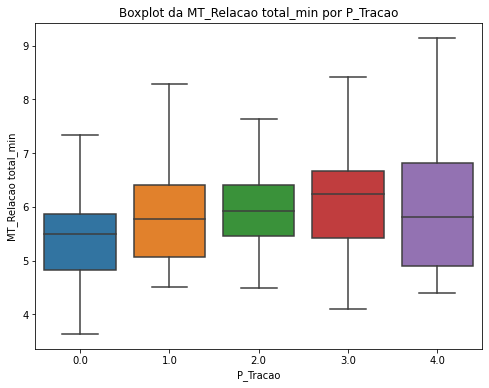

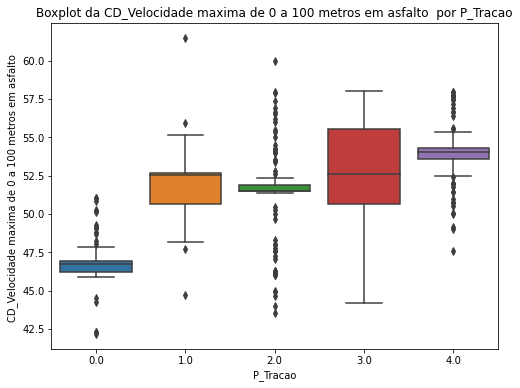

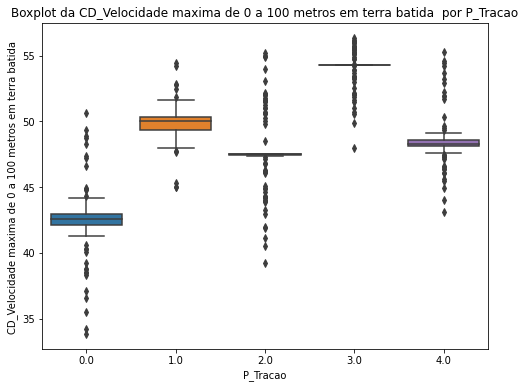

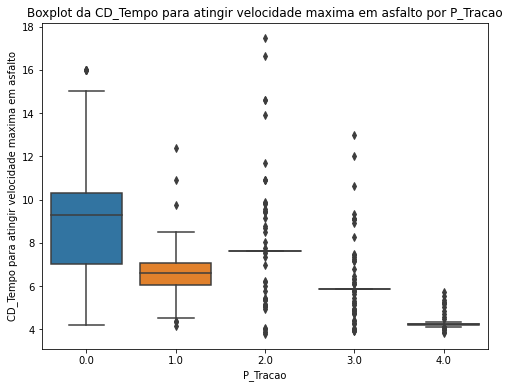

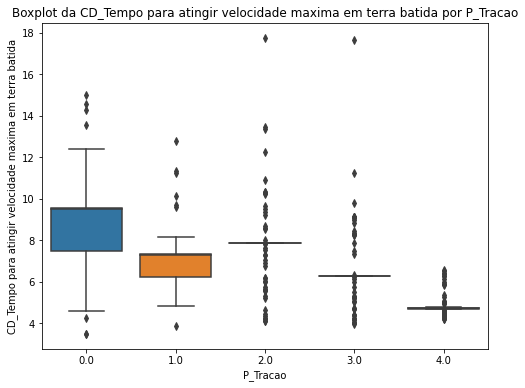

In [15]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Tracao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Tracao', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Tracao')
        plt.ylabel(coluna)
        plt.xlabel('P_Tracao')
        plt.show()

In [16]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [17]:
data_corr = df.drop(['P_Tracao'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

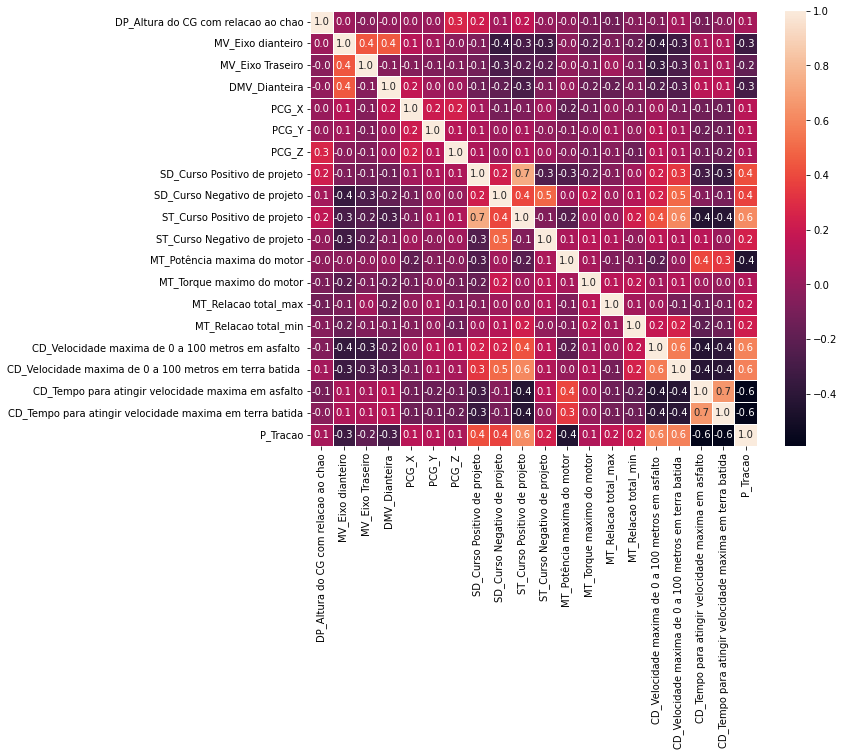

In [18]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [19]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 1

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

      DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                              582.270289  10.511870       0.445076   
2                              589.559597  11.818827       0.445076   
9                              419.766151   7.183329       0.470594   
10                             524.944722   8.125399       0.450733   
12                             524.944722  -0.411953       0.473082   
...                                   ...        ...            ...   
993                            533.172326  -4.370722       0.420099   
995                            548.012531 -21.239980       0.423888   
996                            533.172326  -8.279758       0.400910   
998                            533.172326  -7.520196       0.408075   
1000                           469.600000 -12.704219       0.432000   

           PCG_X       PCG_Y       PCG_Z  SD_Curso Positivo de projeto  \
1     109.203162  -22.428785  248.526573                    172.047372   

In [20]:
# Aplicar PCA para reduzir variáveis de alta correlação - Curso Positivo de projeto
variaveis_reduzidas = df[['SD_Curso Positivo de projeto', 'ST_Curso Positivo de projeto']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'SD_Curso Positivo de projeto',
    'ST_Curso Positivo de projeto',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 6

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Curso Positivo de projeto', variavel_reduzida)

print(df)

      DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                              582.270289  10.511870       0.445076   
2                              589.559597  11.818827       0.445076   
9                              419.766151   7.183329       0.470594   
10                             524.944722   8.125399       0.450733   
12                             524.944722  -0.411953       0.473082   
...                                   ...        ...            ...   
993                            533.172326  -4.370722       0.420099   
995                            548.012531 -21.239980       0.423888   
996                            533.172326  -8.279758       0.400910   
998                            533.172326  -7.520196       0.408075   
1000                           469.600000 -12.704219       0.432000   

           PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1     109.203162  -22.428785  248.526573                 -29.817774   
2    

In [21]:
# Aplicar PCA para reduzir variáveis de alta correlação - Curso Negativo de projeto
variaveis_reduzidas = df[['SD_Curso Negativo de projeto', 'ST_Curso Negativo de projeto']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 7

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Curso Negativo de projeto', variavel_reduzida)

print(df)

      DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                              582.270289  10.511870       0.445076   
2                              589.559597  11.818827       0.445076   
9                              419.766151   7.183329       0.470594   
10                             524.944722   8.125399       0.450733   
12                             524.944722  -0.411953       0.473082   
...                                   ...        ...            ...   
993                            533.172326  -4.370722       0.420099   
995                            548.012531 -21.239980       0.423888   
996                            533.172326  -8.279758       0.400910   
998                            533.172326  -7.520196       0.408075   
1000                           469.600000 -12.704219       0.432000   

           PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1     109.203162  -22.428785  248.526573                 -29.817774   
2    

In [22]:
# Aplicar PCA para reduzir variáveis de alta correlação - CD_Velocidade maxima de 0 a 100 metros
variaveis_reduzidas = df[['CD_Velocidade maxima de 0 a 100 metros em terra batida ', 'CD_Velocidade maxima de 0 a 100 metros em asfalto ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 12

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Velocidade maxima de 0 a 100 metros', variavel_reduzida)

print(df)

      DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                              582.270289  10.511870       0.445076   
2                              589.559597  11.818827       0.445076   
9                              419.766151   7.183329       0.470594   
10                             524.944722   8.125399       0.450733   
12                             524.944722  -0.411953       0.473082   
...                                   ...        ...            ...   
993                            533.172326  -4.370722       0.420099   
995                            548.012531 -21.239980       0.423888   
996                            533.172326  -8.279758       0.400910   
998                            533.172326  -7.520196       0.408075   
1000                           469.600000 -12.704219       0.432000   

           PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1     109.203162  -22.428785  248.526573                 -29.817774   
2    

In [23]:
# Aplicar PCA para reduzir variáveis de alta correlação - CD_Tempo para atingir velocidade maxima
variaveis_reduzidas = df[['CD_Tempo para atingir velocidade maxima em asfalto', 'CD_Tempo para atingir velocidade maxima em terra batida']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 13

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Tempo para atingir velocidade maxima', variavel_reduzida)

print(df)

      DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
1                              582.270289  10.511870       0.445076   
2                              589.559597  11.818827       0.445076   
9                              419.766151   7.183329       0.470594   
10                             524.944722   8.125399       0.450733   
12                             524.944722  -0.411953       0.473082   
...                                   ...        ...            ...   
993                            533.172326  -4.370722       0.420099   
995                            548.012531 -21.239980       0.423888   
996                            533.172326  -8.279758       0.400910   
998                            533.172326  -7.520196       0.408075   
1000                           469.600000 -12.704219       0.432000   

           PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
1     109.203162  -22.428785  248.526573                 -29.817774   
2    

In [25]:
# Remova a última linha do DataFrame e armazene-a em uma variável separada
dados_MB24 = df.iloc[-1]
df = df.iloc[:-1]

dados_MB24 = dados_MB24.drop('P_Tracao')

# Converta a série em um DataFrame com uma única linha
dados_MB24 = dados_MB24.to_frame().T

print(dados_MB24)

     DP_Altura do CG com relacao ao chao     Massa  DMV_Dianteira      PCG_X  \
998                           533.172326 -7.520196       0.408075  588.11564   

         PCG_Y       PCG_Z  Curso Positivo de projeto  \
998  35.287676  542.965184                  -25.91883   

     Curso Negativo de projeto  MT_Potência maxima do motor  \
998                  -4.318914                      6.83882   

     MT_Torque maximo do motor  MT_Relacao total_max  MT_Relacao total_min  \
998                  18.767606             31.104632              4.674379   

     CD_Velocidade maxima de 0 a 100 metros  \
998                               -2.157114   

     CD_Tempo para atingir velocidade maxima  
998                                -3.870747  


## Balanceamento de Classes

In [26]:
# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [27]:
# Verificar o balanceamento original
print('Contagem de classes antes do SMOTE:', Counter(Y))

Contagem de classes antes do SMOTE: Counter({3.0: 115, 2.0: 107, 4.0: 81, 0.0: 80, 1.0: 38})


In [28]:
# Aplicar SMOTE ao conjunto inteiro
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, Y = smote.fit_resample(X, Y)

In [29]:
# Verificar a contagem de classes após o SMOTE
print('Contagem de classes após o SMOTE:', Counter(Y))

Contagem de classes após o SMOTE: Counter({0.0: 115, 1.0: 115, 2.0: 115, 3.0: 115, 4.0: 115})


In [30]:
# Junte X e Y em um único DataFrame
df = pd.concat([X, Y], axis=1)
print(df)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
0                             582.270289  10.511870       0.445076   
1                             589.559597  11.818827       0.445076   
2                             419.766151   7.183329       0.470594   
3                             524.944722   8.125399       0.450733   
4                             524.944722  -0.411953       0.473082   
..                                   ...        ...            ...   
570                           533.172326   8.126381       0.416704   
571                           499.031337   1.453022       0.404031   
572                           533.172326  -3.877492       0.409346   
573                           533.172326   0.768895       0.413019   
574                           552.131689   8.436556       0.406060   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
0    109.203162  -22.428785  248.526573                 -29.817774   
1    108.365923  -1

In [31]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_treino)

     DP_Altura do CG com relacao ao chao      Massa  DMV_Dianteira  \
40                            524.944722   4.295330       0.437535   
314                           478.036783 -14.118325       0.414329   
197                           474.953422 -14.809142       0.439063   
434                           511.098945  10.156525       0.419552   
379                           533.172326  -0.197943       0.412640   
..                                   ...        ...            ...   
447                           624.000653  10.817690       0.460797   
94                            529.406375   3.361100       0.446682   
549                           533.172326   3.798360       0.422769   
43                            524.944722  -2.204067       0.446109   
528                           529.406375  -3.378658       0.410784   

          PCG_X       PCG_Y       PCG_Z  Curso Positivo de projeto  \
40   614.008462   -1.098658  348.428793                  36.654477   
314   73.400335    

In [32]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Treino\\dadostreino_tra.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
dados_treino.to_excel(caminho_arquivo, sheet_name='P_Tracao', index=False)

In [33]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Teste\\dadosteste_tra.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
dados_teste.to_excel(caminho_arquivo, sheet_name='P_Tracao', index=False)

# Pré-seleção do Modelo

## Árvore de Decisão de Classificação

In [34]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

## Classificação de Floresta Aleatória

In [35]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

## Extreme Gradient Boosting

In [36]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Refinamento do Modelo

## Árvore de Decisão de Classificação

In [37]:
# Exemplo de Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Avaliar a qualidade da divisão
    'max_depth': [None, 5, 10, 15],          # Profundidade máxima das árvores 
    'min_samples_split': [2, 5, 10],         # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de amostras em uma folha
    'max_features': [None, 'sqrt', 'log2']   # Número máximo de recursos a serem considerados em cada divisão
}
grid_search = GridSearchCV(estimator=model_DTC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [38]:
# Ajustar um modelo de Árvore de Decisão
model_DTC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_DTC.set_params(**best_params)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)

## Classificação de Floresta Aleatória

In [39]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt']        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_RFC = grid_search.best_params_
best_estimator = grid_search.best_estimator_


540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidPara

In [ ]:
# Guardar os parâmetros encontrados fora do código
#melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
#joblib.dump(melhores_parametros, 'melhores_parametros_acel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_acel.pkl')

In [40]:
# Ajustar um modelo de Floresta Aleatória
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params_RFC)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=20)

## Extreme Gradient Boosting

In [41]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árvores na floresta
    'max_depth': [3, 4, 5],                # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],          # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],          # Fração de amostras usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],        # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],                # Regularização gamma (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_XGB = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [55]:
# Guardar os parâmetros encontrados fora do código
#melhores_parametros = best_params_XGB

# Salvar os melhores parâmetros em um arquivo
#joblib.dump(melhores_parametros, 'melhores_parametros_tra.pkl')

# Carregar os melhores parâmetros a partir do arquivo
best_params_XGB = joblib.load('melhores_parametros_tra.pkl')

['melhores_parametros_tra.pkl']

In [42]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params_XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Validação Cruzada

In [43]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Árvore de Decisão de Classificação

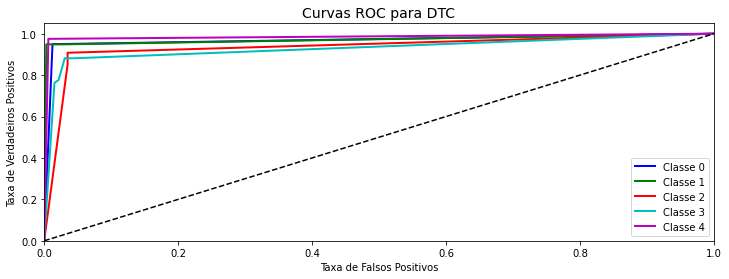

In [44]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_DTC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para DTC', fontsize=14)
plt.show()

In [45]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_DTC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 92.05%
Intervalo de acurácia: [87.51% ~ 96.59%]


In [46]:
# Relatório do modelo
Y_pred = model_DTC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.9444    0.9714    0.9577        35
         1.0     0.9487    1.0000    0.9737        37
         2.0     0.9630    0.9286    0.9455        28
         3.0     0.8500    0.8718    0.8608        39
         4.0     1.0000    0.9118    0.9538        34

    accuracy                         0.9364       173
   macro avg     0.9412    0.9367    0.9383       173
weighted avg     0.9380    0.9364    0.9365       173



## Classificação de Floresta Aleatória

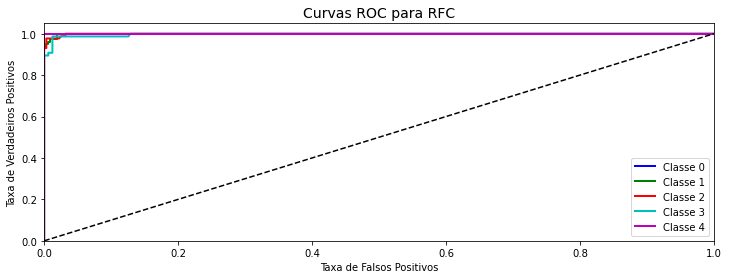

In [47]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para RFC', fontsize=14)
plt.show()

In [48]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 97.01%
Intervalo de acurácia: [95.02% ~ 99.01%]


In [49]:
# Relatório do modelo
Y_pred = model_RFC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        35
         1.0     0.9737    1.0000    0.9867        37
         2.0     1.0000    0.9286    0.9630        28
         3.0     0.9500    0.9744    0.9620        39
         4.0     1.0000    1.0000    1.0000        34

    accuracy                         0.9827       173
   macro avg     0.9847    0.9806    0.9823       173
weighted avg     0.9831    0.9827    0.9826       173



## Extreme Gradient Boosting

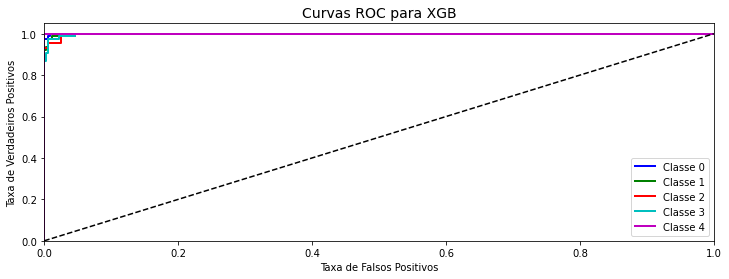

In [50]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para XGB', fontsize=14)
plt.show()

In [51]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 97.26%
Intervalo de acurácia: [93.59% ~ 100.93%]


In [52]:
# Relatório do modelo
Y_pred = model_XGB.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        35
         1.0     0.9737    1.0000    0.9867        37
         2.0     1.0000    0.9286    0.9630        28
         3.0     0.9500    0.9744    0.9620        39
         4.0     1.0000    1.0000    1.0000        34

    accuracy                         0.9827       173
   macro avg     0.9847    0.9806    0.9823       173
weighted avg     0.9831    0.9827    0.9826       173



# Desempate

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento

In [56]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Avaliação

In [57]:
# Fazer previsões no conjunto de teste
Y_pred = model_XGB.predict(X_teste)

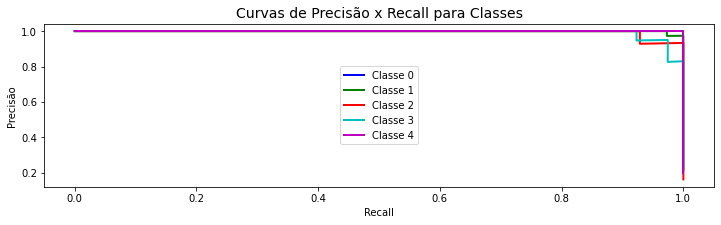

In [58]:
# Comparar scores de Previsão e Recall
# Converta Y_teste para uma matriz binária de classes
Y_bin = label_binarize(Y_teste, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = model_XGB.predict_proba(X_teste)

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

In [59]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
Y_pred = model_XGB.predict(X_teste)

# Calcule a acurácia
accuracy = accuracy_score(Y_teste, Y_pred)

print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Acurácia no conjunto de teste: 0.98


## Análise de Variáveis 

In [60]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.02972839 0.02201218 0.03480194 0.01113071 0.01000228 0.02039878
 0.15740979 0.24052256 0.15285122 0.02496796 0.0084631  0.00863833
 0.19027504 0.08879764]


[20:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 96%|=================== | 827/865 [00:13<00:00]       

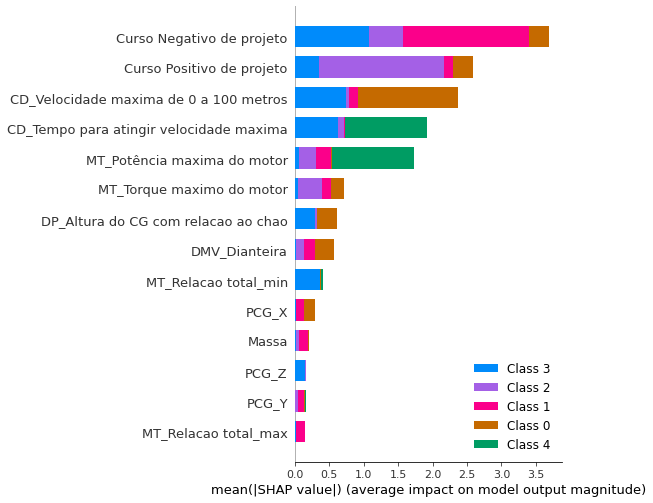

In [61]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Predição

In [63]:
# Valor único para fazer a previsão
X_prev = dados_MB24

# Faça a previsão
previsao = model_XGB.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')

A previsão para X_prev é: 4.00
